# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2024

-----

# Prédiction de la consommation en carburant de voitures récentes.

### Contexte

## TODO

### Objectif

## TODO

### Données
Les données utilisées pour inférer la consommation de carburant sont les suivantes :

## TODO


"annee";"type";"nombre_cylindres";"cylindree";"transmission";"boite";

#### pistes:

preprocessing:

quoi faire avec les variables fortement corrélees, cylindree et nombre cylindres (Supprimer une des deux, soit celle qui a le moins d'impact sur la consommation en carburant, ou les combiner en une seule variable) (ÉTAPE 1)
(si par exemple, on voit une augmentation disproportionnée de la consommation en carburant avec la cylindrée, on pourrait penser à les combiner en une seule variable)
Si nombre_cylindres est une quantité discrète et cylindree est une mesure continue (en litres), leur produit peut être vu comme une "capacité moteur totale", une métrique significative pour des modèles prédictifs.

nouvelle variable comme age du vehicule (2024 - year) (ca reduit l'importance de l'année dans les données) (Comparer avec juste l'enlever pour voir si ca ameliore le modele) (ÉTAPE 2)

reperer les outliers et les traiter

equilibrage des classes (sur ou sous representation des types de vehicules)

zscore normalization sur cylindree (ou nombre cylindres selon chat gpt mais pas certain)

ordinal encoding
one hot encoding (si peu de catégories) : Créez une colonne pour chaque catégorie.



In [3]:
 using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra, MultivariateStats, Distributions

In [24]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


## 1. Étude des données 

In [354]:
training_stats = describe(train)
testing_stats = describe(test)
print("Training Set: \n", training_stats)
print("\n Testing Set: \n", testing_stats)

Training Set: 
7×7 DataFrame
 Row │ variable          mean     min               median  max                    nmissing  eltype   
     │ Symbol            Union…   Any               Union…  Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ annee             2019.15  2014              2019.0  2024                          0  Int64
   2 │ type                       VUS_petit                 voiture_sous_compacte         0  String31
   3 │ nombre_cylindres  5.25237  3                 4.0     12                            0  Int64
   4 │ cylindree                  1,2                       6,4                           0  String3
   5 │ transmission               4x4                       traction                      0  String15
   6 │ boite                      automatique               manuelle                      0  String15
   7 │ consommation               10,2265217391304       

# 2. Exploration des données

## 2.1 Helpers

In [6]:
function safe_parse_int(x)
    try
        parse(Int, x)
    catch
        missing
    end
end

safe_parse_int (generic function with 1 method)

In [6]:
function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

safe_parse_float (generic function with 1 method)

In [8]:
function one_hot_encode(df, cols, levels_dict)
    for col in cols
        levels_col = levels_dict[col]
        for level in levels_col
            new_col = Symbol(string(col) * "_" * string(level))
            df[!, new_col] = ifelse.(df[!, col] .== level, 1.0, 0.0)
        end
        # Remove the original column
        select!(df, Not(col))
    end
    return df
end

one_hot_encode (generic function with 1 method)

# 2.2 Analyse des données

Commençons par nous familiariser avec les données à notre disposition. Dans cette section, nous allons explorer différentes pistes qui pourraient potentiellement avoir un impact positif sur nos prédictions, que ce soit de répérer des données éloignées du reste de l'ensemble, de répérer des tendances, de détecter des instances de multicolinéarité, etc.

La première étape pour traiter les données est de copier les données d'entraînement dans une variable "data" afin d'éviter de corrompre les données originales lors de nos manipulations. On peut ensuite retirer les variables manquantes.

In [358]:
# faire une copie initiale du dataframe
data = deepcopy(train)

# retirer les colonnes ayant des données vides de notre dataframe
data = dropmissing(data)

first(data, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2023,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"
2,2020,VUS_petit,4,2,integrale,automatique,"9,80041666666667"
3,2021,voiture_compacte,6,"3,3",propulsion,automatique,"11,7605"
4,2023,voiture_deux_places,8,5,integrale,automatique,"13,0672222222222"
5,2022,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"


### Variables explicatives

Nous allons commencer par analyser chacune des variables explicatives potentielles en détail.

#### Année

La première variable explicative est l'année de fabrication du véhicule. Nous avons commencé par regarder la tendance de la consommation d'essence au fil des ans.

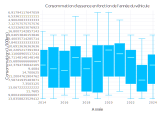

In [359]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:annee,
    y=:consommation,
    Geom.boxplot,
    Guide.title("Consommation d'essence en fonction de l'année du véhicule"),
    Guide.xlabel("Année"),
    Guide.ylabel("Consommation (L/100km)"),
)

On peut tirer quelques observations de ce diagramme. D'abord, les données de l'ensemble d'entraînement sont réparties sur une période de seulement 10 ans, soit de 2014 à 2024. Ceci fait en sorte que les consommations d'essence correspondantes varieront peu d'une année à l'autre, car les véhicules ne se sont pas améliorés technologiquement de façon assez significative sur une aussi courte période pour que l'année de fabrication ait une incidence notable sur la consommation d'essence. De plus, lorsqu'on observe le diagramme, il est difficile de remarquer une tendance claire dans la variation de la consommation d'essence sur la période de 10 ans. La consommation d'essence semblait être à la hausse entre 2018 et 2020, puis s'est stabilisée avant de rechuter en 2023. Ces variations nous semblent difficiles à modéliser. Pour toutes ces raisons, il nous semble initialement que l'année de fabrication soit une variable explicative de faible impact sur les prédictions.

Ensuite, nous nous sommes questionné quant à la grosseur des chiffres reliées à l'année dans un modèle. En effet, les autres données numériques étant le nombre de cylindres et la cylindrée, qui ont tous les deux des valeurs nettement inférieures à un chiffre comme 2020, nous nous demandions si cette disparité pouvait avoir un impact sur la qualité de nos prédictions. Nous avons donc opté pour la stratégie de changer la variable explicative de l'année de fabrication pour une variable d'âge, qui serait entre 1 et 10 ans, et qui serait beaucoup plus proche des valeurs des autres variables explicatives. Ci-dessous se trouve notre façon de procéder.

In [360]:
data.age = 2024 .- data.annee

select!(data, Not(:annee))
first(data, 5)

Row,type,nombre_cylindres,cylindree,transmission,boite,consommation,age
,String31,Int64,String3,String15,String15,String31,Int64
1,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412",1
2,VUS_petit,4,2,integrale,automatique,"9,80041666666667",4
3,voiture_compacte,6,"3,3",propulsion,automatique,"11,7605",3
4,voiture_deux_places,8,5,integrale,automatique,"13,0672222222222",1
5,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412",2


In [361]:
# Résumé des données
println(describe(data))

7×7 DataFrame
 Row │ variable          mean     min               median  max                    nmissing  eltype   
     │ Symbol            Union…   Any               Union…  Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ type                       VUS_petit                 voiture_sous_compacte         0  String31
   2 │ nombre_cylindres  5.25237  3                 4.0     12                            0  Int64
   3 │ cylindree                  1,2                       6,4                           0  String3
   4 │ transmission               4x4                       traction                      0  String15
   5 │ boite                      automatique               manuelle                      0  String15
   6 │ consommation               10,2265217391304          9,80041666666667              0  String31
   7 │ age               4.85174  0                 5.0     10       

# Corrélation entre les variables

In [362]:
numeric_cols = [:annee, :nombre_cylindres, :cylindree, :consommation]

M = cor(Matrix(data[:, numeric_cols]))

# Afficher la matrice de corrélation
println("Matrice de corrélation :")
println(M)

# PLOT
(n,m) = size(M)
heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,numeric_cols), xrot=90, yticks=(1:m,numeric_cols), yflip=true)
annotate!([(j, i, text(round(M[i,j],digits=3), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])

ArgumentError: ArgumentError: column name :annee not found in the data frame

1. `nombre_cylindres` et `cylindree` est très élevée, ce qui indique une forte relation positive. Cela suggère que le nombre de cylindres est fortement associé à la cylindrée des véhicules.

2. La corrélation entre `cylindree` et `consommation` est également élevée, montrant qu'une augmentation de la cylindrée est associée à une augmentation de la consommation (par exemple, les moteurs plus gros consomment plus de carburant).

3. Une corrélation similaire existe entre `nombre_cylindres` et `consommation`, ce qui est logique, car le nombre de cylindres et la cylindrée sont liés.

4. Les corrélations entre annee et les autres variables sont faibles et négatives, indiquant que les variables comme le nombre de cylindres, la cylindrée et la consommation ont légèrement diminué avec le temps.

## Consommation par type de véhicule

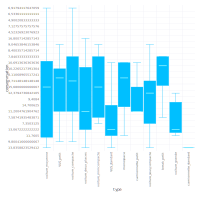

In [363]:
set_default_plot_size(20cm, 20cm)
Gadfly.plot(train, x=:type, y=:consommation, Geom.boxplot )

In [364]:
unique_categories = unique(skipmissing(data[:, :type]))
occurences = [sum(skipmissing(data[:, :type]) .== category) for category in unique_categories]
occurences = DataFrame(category = unique_categories, occurences = occurences)
occurences = occurences[occurences.occurences .> 10, :] #TODO INVESTIGATE 

Row,category,occurences
,String31,Int64
1,voiture_moyenne,28
2,VUS_petit,86
3,voiture_compacte,49
4,voiture_deux_places,40
5,voiture_minicompacte,17
6,VUS_standard,17
7,voiture_sous_compacte,54


Consommation en fonction du type véhicule moyen :

In [365]:
set_default_plot_size(20cm, 20cm)
vehicule_moyenne = filter(row -> row.type == "voiture_moyenne", data)
Gadfly.plot(vehicule_moyenne, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type VUS_petit

In [366]:
set_default_plot_size(20cm, 20cm)
vehicule_VUSp = filter(row -> row.type == "VUS_petit", data)
Gadfly.plot(vehicule_VUSp, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type véhicule compacte

In [367]:
set_default_plot_size(20cm, 20cm)
voiture_compacte = filter(row -> row.type == "voiture_compacte", data)
Gadfly.plot(voiture_compacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type véhicule 2 places

In [368]:
set_default_plot_size(20cm, 20cm)
voiture_deux_places = filter(row -> row.type == "voiture_deux_places", data)
Gadfly.plot(voiture_deux_places, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type véhicule camionnette standard

In [369]:
set_default_plot_size(20cm, 20cm)
camionnette_standard = filter(row -> row.type == "camionnette_standard", data)
Gadfly.plot(camionnette_standard, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type véhicule mini compacte

In [370]:
set_default_plot_size(20cm, 20cm)
voiture_minicompacte = filter(row -> row.type == "voiture_minicompacte", data)
Gadfly.plot(voiture_minicompacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type véhicule VUS standard

In [371]:
set_default_plot_size(20cm, 20cm)
VUS_standard = filter(row -> row.type == "VUS_standard", data)
Gadfly.plot(VUS_standard, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

Consommation en fonction du type véhicule sous-compacte

In [372]:
set_default_plot_size(20cm, 20cm)
voiture_sous_compacte = filter(row -> row.type == "voiture_sous_compacte", data)
Gadfly.plot(voiture_sous_compacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

ArgumentError: ArgumentError: column name :annee not found in the data frame

## Consommation par cylindrée

## Consommation par nombre de cylindres

## Consommation par année //TODO METTRE UNE NOTE COMME QUOI PAS BESOIN D'INVESTIGUER

## Consommation par type de transmission 

In [373]:
#Prétraitement:


datasets_with_consommation = [data]

# Apply replacements to 'cylindree' in all datasets
for df in [data]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [data]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

En ce qui concerne le type de transmission, nous avons commencé par observer la distribution des catégories:

In [374]:
for df in [data]
    println("Nombre d'observations par type de transmission :")
    println(combine(groupby(df, :transmission), nrow))
end

Nombre d'observations par type de transmission :
4×2 DataFrame
 Row │ transmission  nrow  
     │ String15      Int64 
─────┼─────────────────────
   1 │ integrale       126
   2 │ propulsion       63
   3 │ traction        110
   4 │ 4x4              18


Comme nous pouvons le voir, les types de transmission sont représentées inégalement dans l'ensemble de données. Les transmissions integrale et à traction sont largement représentées, tandis que les transmissions à propulsion et 4x4 sont sous-représentées. Cela nous mène à questionner l'effet de ce manque sur les prédictions. Effectivement, si les types de transmission sont corrélés à la consommation d'essence, le fait que certaines catégories soient sous-représentées pourrait biaiser nos prédictions.

In [ ]:
# Histogramme de la consommation moyenne en fonction du type de transmission
set_default_plot_size(20cm, 20cm)

mean_consommation = combine(groupby(data, :transmission), :consommation => mean => :mean_consommation)
# moyenne par type de transmission
println(mean_consommation)

Gadfly.plot(
    mean_consommation,
    x=:transmission,
    y=:mean_consommation,
    Geom.bar,
    Guide.xlabel("Transmission"),
    Guide.ylabel("Consommation moyenne (L/100km)"),
    Guide.title("Consommation moyenne en fonction du type de transmission")
)

4×2 DataFrame
 Row │ transmission  mean_consommation 
     │ String15      Float64           
─────┼─────────────────────────────────
   1 │ integrale              11.1466
   2 │ propulsion             11.1808
   3 │ traction                8.56099
   4 │ 4x4                    11.7382


Comme, les prédictions risquent d'être biaisées vers des valeurs associées aux classes majoritaires ("integrale" ou "traction"), nous pourrions poser l'hypothèse que le modèle risque de sous-estimer non seulement la consommation des véhicules avec une transmission 4x4 et propulsion, mais aussi les prédictions globales en raison de la forte représentation de la transmission traction. (Voir histogramme de la consommation par type de transmission). Pour pallier à ce problème, nous pourrions envisager de pondérer ou de regrouper les classes de transmission pour équilibrer les données. Par exemple, nous pourrions ajouter un poids élevé à la classe "4x4" et un poids plus faible à la classe "Traction" pour compenser leur représentation respective. Nous pourrions également regrouper les classes "Intégrale" et "Propulsion" en une seule catégorie pour augmenter leur représentation dans l'ensemble de données, si leur distinction n'apporte pas de valeur ajoutée au modèle.

baseline model linear regression

In [ ]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

In [ ]:
# # Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
# model with all variables

@time model = lm(@formula(consommation ~ transmission_propulsion + transmission_traction + transmission_integrale + transmission_4x4), train)

In [ ]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(model, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
#v = Int.(round.(valid_prediction, digits=0)) #mettre une commentaire sur la difference que ca entraine sur le rmse
# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
println("RMSE: ", rmse_valid)

RMSE de base: 1.7

#### Approche A: Ajustement de poids

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

In [ ]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

In [ ]:
counts = combine(groupby(train, :transmission), nrow => :nrow)

# Step 2: Calculate total number of observations and number of classes
total_samples = sum(counts.nrow)
num_classes = nrow(counts)

# Step 3: Compute weights for each transmission type
counts.Weight = total_samples ./ (num_classes .* counts.nrow)

# Step 4: Merge weights back into the original DataFrame
train = leftjoin(train, counts[:, [:transmission, :Weight]], on=:transmission)

In [ ]:
# Define categorical columns
categorical_cols = [:transmission,:type]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)

In [ ]:
describe(train)
dropmissing!(train)

In [ ]:
# Ajuster le modèle avec les poids

@time modelA = fit(LinearModel, @formula(consommation ~ transmission_propulsion + transmission_traction + transmission_integrale + transmission_4x4), train, wts = train.Weight)

In [ ]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(modelA, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
#v = Int.(round.(valid_prediction, digits=0)) #mettre une commentaire sur la difference que ca entraine sur le rmse
# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
println("RMSE: ", rmse_valid)

Pour l'approche A, le rmse nous donne 1.081 ce qui signifie que les prédicitons ne sont pas affectées positivement à l'ajout de poids selon la transmissions. Nous avons donc décidé de ne pas utiliser cette approche. 

#### Approche B: Combinaison de catégories similaires 

Nous devons tester la significativité statistique de la différence entre les catégories de transmission. Pour ce faire, nous avons effectué un test ANOVA pour comparer les moyennes de consommation d'essence entre les différentes catégories de transmission.

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

In [ ]:
train_data = deepcopy(train)
valid_data = deepcopy(valid)

# Datasets that contain 'consommation'
datasets_with_consommation = [train_data, valid_data]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train_data, valid_data, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train_data, valid_data, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train_data, valid_data, test]
    dropmissing!(df)
end

In [ ]:
# Fonction pour calculer la moyenne

function t_test_equal_variances(group1, group2)
    # Tailles des échantillons
    n1 = length(group1)
    n2 = length(group2)

    # Moyennes des deux groupes
    μ1 = mean(group1)
    μ2 = mean(group2)

    # Variances des deux groupes
    s1² = var(group1)
    s2² = var(group2)

    # Variance combinée pondérée
    sp² = ((n1 - 1) * s1² + (n2 - 1) * s2²) / (n1 + n2 - 2)

    # Statistique t
    t_stat = (μ1 - μ2) / sqrt(sp² * (1 / n1 + 1 / n2))

    # Degrés de liberté
    df = n1 + n2 - 2

    # p-valeur approximative (bilatérale) avec la loi de Student
    # Approximation pour t-distribution : 2 * (1 - cdf(gaussian, abs(t_stat)))
    # ou intégrer avec des librairies de tables t pour une solution complète.
    return t_stat, df
end

In [ ]:

# Exemple d'utilisation
group_integrale = train_data[train_data.transmission .== "integrale", :consommation]
group_propulsion = train_data[train_data.transmission .== "propulsion", :consommation]

# Calcul du test t
t_stat, df = t_test_equal_variances(group_integrale, group_propulsion)

absolut_t_stat = abs(t_stat)

pvalue = 2 * (1 - cdf(TDist(df), absolut_t_stat))

println("Statistique t : $absolut_t_stat")
println("p-valeur : $pvalue")
println("Degrés de liberté : $df")

Comme le test de student nous donne une p-value > 0.05, nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle les moyennes de consommation d'essence entre les différentes catégories de transmission sont égales. Cela signifie que les différences de consommation d'essence entre les catégories de transmission ne sont pas statistiquement significatives. Par conséquent, nous pouvons regrouper les catégories de transmission similaires pour augmenter leur représentation dans l'ensemble de données sans affecter la qualité des prédictions.

In [ ]:
# Create a new column with the grouped categories
# if transmission is 4x4, change for integrale
train_data.transmission = ifelse.(train_data.transmission .== "4x4", "integrale", train_data.transmission)
valid_data.transmission = ifelse.(valid_data.transmission .== "4x4", "integrale", valid_data.transmission)

In [ ]:
# # Encode 'boite' column in all datasets
for df in [train_data, valid_data, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train_data[!, col])
end

train_data = one_hot_encode(train_data, categorical_cols, levels_dict)
valid_data = one_hot_encode(valid_data, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

println(names(train_data))

In [ ]:
@time modelB = lm(@formula(consommation ~ 
    transmission_integrale + transmission_traction + transmission_propulsion), train_data)

In [ ]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(modelB, valid_data)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
#v = Int.(round.(valid_prediction, digits=0)) #mettre une commentaire sur la difference que ca entraine sur le rmse
# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid_data.consommation).^2))
println("RMSE: ", rmse_valid)

# 3. Régression linéaire

In [3]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]


Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [ ]:
# capacite_moteur = :nombre_cylindres * :cylindree

In [4]:
## convert annee column into age
train.age = 2024 .- train.annee
valid.age = 2024 .- valid.annee
test.age = 2024 .- test.annee

train = select!(train, Not(:annee))
valid = select!(valid, Not(:annee))
test = select!(test, Not(:annee))

## drop missing values
train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

Row,type,nombre_cylindres,cylindree,transmission,boite,age
,String31,Int64,String3,String15,String15,Int64
1,voiture_moyenne,4,"2,5",traction,manuelle,10
2,voiture_moyenne,4,"2,5",traction,automatique,10
3,VUS_petit,4,"2,5",traction,automatique,10
4,VUS_petit,4,2,4x4,automatique,10
5,voiture_sous_compacte,8,"5,8",propulsion,manuelle,10
6,voiture_sous_compacte,8,5,propulsion,automatique,10
7,voiture_sous_compacte,8,5,propulsion,manuelle,10
8,VUS_petit,4,"2,4",4x4,automatique,10
9,VUS_petit,6,"3,5",integrale,automatique,10


In [9]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# # Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end


In [ ]:
# # Create a new column with the grouped categories
# # if transmission is 4x4, change for integrale
# train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)
# train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)

In [10]:
# Define categorical columns
categorical_cols = [:type, :transmission, :boite]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

Row,nombre_cylindres,cylindree,age,type_voiture_moyenne,type_VUS_petit,type_voiture_compacte,type_voiture_deux_places,type_voiture_minicompacte,type_VUS_standard,type_monospace,type_camionnette_petit,type_voiture_sous_compacte,type_break_petit,type_voiture_grande,type_camionnette_standard,transmission_integrale,transmission_propulsion,transmission_traction,transmission_4x4,boite_1.0,boite_0.0
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,4,2.5,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,4,2.5,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,4,2.5,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,2.0,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5,8,5.8,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,8,5.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,8,5.0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,4,2.4,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,6,3.5,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# normalize the data
function standardizer(X, means, stds)
    X = deepcopy(X)
    for j in 1:size(X, 2)
        if j in numeric_indices
            X[:, j] = (X[:, j] .- means[j]) ./ stds[j]
        end
    end
    return X
end

# cols_to_normalize = [:age, :capacite_moteur]

# means = [mean(train[!, col]) for col in cols_to_normalize]
# stds = [std(train[!, col]) for col in cols_to_normalize]

# train[!, cols_to_normalize] = standardizer(Matrix(train[!, cols_to_normalize]), means, stds)
# valid[!, cols_to_normalize] = standardizer(Matrix(valid[!, cols_to_normalize]), means, stds)


standardizer (generic function with 1 method)

In [12]:
# print every column in the dataframe

rename!(train, "boite_0.0" => "boite_0", "boite_1.0" => "boite_1")
rename!(valid, "boite_0.0" => "boite_0", "boite_1.0" => "boite_1")


for col in names(train)
    println(col)
end


nombre_cylindres
cylindree
consommation
age
type_voiture_moyenne
type_VUS_petit
type_voiture_compacte
type_voiture_deux_places
type_voiture_minicompacte
type_VUS_standard
type_monospace
type_camionnette_petit
type_voiture_sous_compacte
type_break_petit
type_voiture_grande
type_camionnette_standard
transmission_integrale
transmission_propulsion
transmission_traction
transmission_4x4
boite_1
boite_0


In [13]:
using GLM

# Define all formulas for models
model_formulas = [
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + nombre_cylindres),
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree),
    @formula(consommation ~ age + transmission_integrale),
    @formula(consommation ~ age + nombre_cylindres + cylindree ),
    @formula(consommation ~ nombre_cylindres + cylindree + age + 
    type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte +
    type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard +
    transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + boite_0 + boite_1),
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte +
    type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard),
    @formula(consommation ~ age + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte +
    type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard)

]

# Fit each model and calculate BIC
# Fit models and calculate BIC
models = []
bics = []
rmses = []
for formula in model_formulas
    model = lm(formula, train)
    push!(models, model)
    push!(bics, GLM.bic(model))
    
    # Calculate RMSE on validation set
    valid_prediction = GLM.predict(model, valid)
    rmse = sqrt(mean((valid_prediction - valid.consommation).^2))
    push!(rmses, rmse)
end

# Find the best model by BIC and RMSE
best_bic_index = argmin(bics)
best_rmse_index = argmin(rmses)

println("Best Model by BIC: ", model_formulas[best_bic_index])
println("BIC: ", bics[best_bic_index])
println("Best Model by RMSE: ", model_formulas[best_rmse_index])
println("RMSE: ", rmses[best_rmse_index])



Best Model by BIC: consommation ~ nombre_cylindres + cylindree + age + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte + type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + boite_0 + boite_1
BIC: 935.9872332180056
Best Model by RMSE: consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree
RMSE: 0.8461751133069092


In [16]:
model = lm(@formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree), train)
#model = lm(@formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + nombre_cylindres), train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

consommation ~ 1 + age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                              Coef.   Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)               6.77021      0.325678    20.79    <1e-60    6.1294       7.41102
age                       0.0206045    0.0188532    1.09    0.2753   -0.0164915    0.0577005
transmission_integrale    0.0457026    0.262924     0.17    0.8621   -0.471632     0.563037
transmission_propulsion  -0.349797     0.276533    -1.26    0.2068   -0.893909     0.194315
transmission_traction    -1.11

In [17]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(model, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
#v = Int.(round.(valid_prediction, digits=0)) #mettre une commentaire sur la difference que ca entraine sur le rmse
# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
println("RMSE: ", rmse_valid)

RMSE: 0.8461751133069092


In [ ]:
n = nrow(test)

id = 1:n

ŷ = GLM.predict(model, test)

df_pred = DataFrame(id=id, consommation=ŷ)

name = "linear/" * string(rmse_valid) * ".csv"
CSV.write("../submissions/" * name, df_pred)
println("Predictions exported successfully to " * name*".")

# 4. Régression bayesienne

In [ ]:
## convert annee column into age
train.age = 2024 .- train.annee
valid.age = 2024 .- valid.annee
test.age = 2024 .- test.annee

train = select!(train, Not(:annee))
valid = select!(valid, Not(:annee))
test = select!(test, Not(:annee))

## drop missing values
train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

In [ ]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# #cols_to_normalize = [:cylindree, :age, :nombre_cylindres]
# train = normalize(train, cols_to_normalize)
# valid = normalize(valid, cols_to_normalize)
# test = normalize(test, cols_to_normalize)


In [ ]:
# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
y_train = train.consommation
X_train = select(train, Not(:consommation))
y_valid = valid.consommation
X_valid = select(valid, Not(:consommation))
X_test = deepcopy(test)


In [ ]:
# Identify numeric feature indices
feature_names = names(train)
numeric_features = [ :cylindree, :nombre_cylindres, :age]
numeric_indices = findall(x -> x in numeric_features, feature_names)

means = mean(Matrix(X_train[:, numeric_features]), dims=1)
stds = std(Matrix(X_train[:, numeric_features]), dims=1)

In [ ]:
function standardizer(X, means, stds)
    X = deepcopy(X)
    for j in 1:size(X, 2)
        if j in numeric_indices
            X[:, j] = (X[:, j] .- means[j]) ./ stds[j]
        end
    end
    return X
end

In [ ]:
X_train = standardizer(Matrix(X_train), means, stds)
X_valid = standardizer(Matrix(X_valid), means, stds)
X_test = standardizer(Matrix(X_test), means, stds)

y_train = Vector(y_train)
y_valid = Vector(y_valid)

In [ ]:
# Ridge regression with cross-validation
XtX = X_train' * X_train
Xty = X_train' * y_train
n_features = size(X_train, 2)

In [ ]:
describe(valid)

In [ ]:
lambda_values = 10 .^ range(-5, stop=5, length=1000)
best_rmse = Inf
best_lambda = 0.0
best_beta = nothing


for λ in lambda_values
    beta = (XtX + λ * I) \ Xty
    y_pred_valid = X_valid * beta
    rmse = sqrt(mean((y_pred_valid - y_valid).^2))
    println("Lambda: ", λ, " RMSE: ", rmse)
    if rmse < best_rmse
        best_rmse = rmse
        best_lambda = λ
        best_beta = beta
    end
end

println("Best Lambda: ", best_lambda)
println("Best RMSE: ", best_rmse)

In [ ]:
# # Evaluation on validation set
y_valid_pred = X_valid * best_beta
rmse_valid = sqrt(mean((y_valid_pred - y_valid).^2))
println("Validation RMSE: ", rmse_valid)

# Predictions on test set
y_test_pred = X_test * best_beta

# Prepare submission DataFrame
n_test = size(y_test_pred, 1)
id = 1:n_test
df_pred = DataFrame(id=id, consommation=y_test_pred)

name = "ridge" * string(rmse_valid) * ".csv"
CSV.write("../submissions/" * name, df_pred)
println("Predictions exported successfully to " * name*".")

# Validation par k-fold cross-validation

In [ ]:
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5  
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    test_indices = indices[(i*fold_size + 1):min((i+1)*fold_size, n)]
    train_indices = setdiff(indices, test_indices)
    
    train_data = data_k_folds[train_indices, :]
    test_data = data_k_folds[test_indices, :]
    
    model = lm(@formula(consommation ~ age  + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree), data_k_folds)
 
    
    valid_prediction = GLM.predict(model, test_data)
    
    mean_prediction = mean(skipmissing(valid_prediction))
    valid_prediction = coalesce.(valid_prediction, mean_prediction)
    
    if any(ismissing, valid_prediction)
        error("Skip les valeur missing")
    end
    
    v = max.(valid_prediction, 0) 
    
    score = sqrt(mean((v - test_data.consommation).^2))
    push!(rms_scores, score)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE : $moyenne_rmse")

# Régression par l'approche des composantes principales

In [42]:
Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]

# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end


# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)


# Drop unnecessary columns
# train = select(train, Not([:type, :transmission, :boite]))
# valid = select(valid, Not([:type, :transmission, :boite]))


Row,annee,nombre_cylindres,cylindree,boite,type_voiture_moyenne,type_VUS_petit,type_voiture_compacte,type_voiture_deux_places,type_voiture_minicompacte,type_VUS_standard,type_monospace,type_camionnette_petit,type_voiture_sous_compacte,type_break_petit,type_voiture_grande,type_camionnette_standard,transmission_integrale,transmission_propulsion,transmission_traction,transmission_4x4
,Int64,Int64,String3,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014,4,"2,5",manuelle,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2014,4,"2,5",automatique,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2014,4,"2,5",automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2014,4,2,automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2014,8,"5,8",manuelle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2014,8,5,automatique,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,2014,8,5,manuelle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,2014,4,"2,4",automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2014,6,"3,5",automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


###### TODO CONCLUSION

In [37]:
numeric_cols = setdiff(names(train)[eltype.(eachcol(train)) .<: Real], [:consommation])
X_train = Matrix(select(train, numeric_cols))

y_train = Vector(train.consommation)

317-element Vector{Float64}:
 13.8358823529412
  9.80041666666667
 11.7605
 13.0672222222222
 13.8358823529412
 13.8358823529412
  7.3503125
  7.58741935483871
 11.2004761904762
 11.7605
  ⋮
 12.3794736842105
  9.80041666666667
  7.84033333333333
  8.71148148148148
 10.2265217391304
 12.3794736842105
 11.2004761904762
  7.84033333333333
  9.04653846153846

In [38]:
X_mean = mean(X_train; dims=1)
X_stddev = std(X_train; dims=1, corrected=false)
X_train_std = (X_train .- X_mean) ./ X_stddev
X_valid = Matrix(select(valid, numeric_cols))


79×20 Matrix{Float64}:
 2024.0  8.0  4.4  12.3795   1.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2024.0  6.0  3.0   9.80042  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 2021.0  6.0  3.0  10.6914   0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 2018.0  4.0  2.0   9.4084   0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 2015.0  8.0  6.2  14.7006   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2021.0  4.0  2.0   7.58742  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2018.0  4.0  2.0   8.71148  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2014.0  8.0  4.8  13.8359   0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2022.0  8.0  4.4  12.3795   0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2023.0  4.0  2.0  12.3795   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
    ⋮                             ⋮    ⋱            ⋮                   
 2016.0  4.0  2.0   8.71148  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2016.0  4.0  1.6   7.58742  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1

In [73]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [74]:
using MultivariateStats
using GLM

# Data Cleaning and Preparation
Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]

# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

for col in [:cylindree]
    test[!, col] = replace.(test[!, col], "," => ".")
    test[!, col] = safe_parse_float.(test[!, col])
end

# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)





Row,annee,nombre_cylindres,cylindree,boite,type_voiture_moyenne,type_VUS_petit,type_voiture_compacte,type_voiture_deux_places,type_voiture_minicompacte,type_VUS_standard,type_monospace,type_camionnette_petit,type_voiture_sous_compacte,type_break_petit,type_voiture_grande,type_camionnette_standard,transmission_integrale,transmission_propulsion,transmission_traction,transmission_4x4
,Int64,Int64,Float64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014,4,2.5,manuelle,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2014,4,2.5,automatique,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2014,4,2.5,automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2014,4,2.0,automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2014,8,5.8,manuelle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2014,8,5.0,automatique,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,2014,8,5.0,manuelle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,2014,4,2.4,automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2014,6,3.5,automatique,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Define numeric columns
numeric_cols = select(names(train), Not(:consomamtion))

#numeric_cols_test = setdiff(names(test)[eltype.(eachcol(test)) .<: Real])

# Extract numeric columns
X_train = Matrix(select(train, numeric_cols))
y_train = Vector(train.consommation)
X_valid = Matrix(select(valid, numeric_cols))
y_valid = Vector(valid.consommation)
X_test = Matrix(select(test, numeric_cols))


150×19 Matrix{Float64}:
 2014.0   4.0  2.5  1.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0   4.0  2.5  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0   4.0  2.5  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 2014.0   4.0  2.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0   8.0  5.8  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 2014.0   8.0  5.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 2014.0   8.0  5.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 2014.0   4.0  2.4  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 2014.0   6.0  3.5  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2014.0  10.0  5.2  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
    ⋮                         ⋮         ⋱                 ⋮              
 2024.0   4.0  2.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 2024.0   4.0  2.0  0.0  1.0  0.0  0.0     0.0  0.0  0.

In [76]:
for col in numeric_cols
    println(col)
end

annee
nombre_cylindres
cylindree
consommation
type_voiture_moyenne
type_VUS_petit
type_voiture_compacte
type_voiture_deux_places
type_voiture_minicompacte
type_VUS_standard
type_monospace
type_camionnette_petit
type_voiture_sous_compacte
type_break_petit
type_voiture_grande
type_camionnette_standard
transmission_integrale
transmission_propulsion
transmission_traction
transmission_4x4


In [77]:
for col in numeric_cols_test
    println(col)
end

annee
nombre_cylindres
cylindree
type_voiture_moyenne
type_VUS_petit
type_voiture_compacte
type_voiture_deux_places
type_voiture_minicompacte
type_VUS_standard
type_monospace
type_camionnette_petit
type_voiture_sous_compacte
type_break_petit
type_voiture_grande
type_camionnette_standard
transmission_integrale
transmission_propulsion
transmission_traction
transmission_4x4


In [72]:
# Standardize the data
X_mean = mean(X_train; dims=1)
X_stddev = std(X_train; dims=1, corrected=false)
X_train_std = (X_train .- X_mean) ./ X_stddev
X_valid_std = (X_valid .- X_mean) ./ X_stddev
X_test_std = (X_test .- X_mean) ./ X_stddev

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 19 and 20

In [31]:
# Perform PCA
pca_model = fit(PCA, X_train_std'; maxoutdim=5)
Z_train = MultivariateStats.transform(pca_model, X_train_std')'
Z_valid = MultivariateStats.transform(pca_model, X_valid_std')'
Z_test = MultivariateStats.transform(pca_model, X_test_std')'

# Add principal components to DataFrames (train and valid)
for i in 1:size(Z_train, 2)
    train[:, "PC$(i)"] = Z_train[:, i]
    valid[:, "PC$(i)"] = Z_valid[:, i]
    test[:, "PC$(i)"] = Z_test[:, i]
end

# Fit a regression model using PCA
model_with_pca = lm(@formula(consommation ~ PC1 + PC2 + PC3 + PC4 + PC5), train)

# Predict on validation data
valid_prediction_with_pca = predict(model_with_pca, valid)
test_prediction_with_pca = predict(model_with_pca, test)

# Calculate RMSE
rmse_with_pca = sqrt(mean((valid_prediction_with_pca - valid.consommation).^2))
println("RMSE with PCA: ", rmse_with_pca)

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 19 and 20

In [ ]:
# Prepare submission DataFrame
n_test = size(test_prediction_with_pca, 1)
id = 1:n_test
df_pred = DataFrame(id=id, consommation=test_prediction_with_pca)

name = "pca" * string(rmse_with_pca) * ".csv"
CSV.write("../submissions/" * name, df_pred)
println("Predictions exported successfully to " * name*".")

In [ ]:
using MultivariateStats MultivariateStats
using
using GLM GLM
using
using Random Random
using
using DataFrames DataFrames

#

# Ensure Ensure the the :consommation :consommation column column is is present present in in full_train full_train
if
if !haskey(full_train, !haskey(full_train, :consommation) :consommation)
    error("The
    error("The column column :consommation :consommation is is not not found found in in the the full_train full_train data data frame.") frame.")
end
end

#

# Data Data Cleaning Cleaning and and Preparation Preparation
Random.seed!(1234)
Random.seed!(1234) # # For For reproducibility reproducibility

#

# Split Split the the data data into into training, training, validation, validation, and and testing testing datasets datasets
ntotal
ntotal = = nrow(full_train) nrow(full_train)
ntrain
ntrain = = round(Int, round(Int, 0.7 0.7 * * ntotal) ntotal)
nvalid
nvalid = = round(Int, round(Int, 0.2 0.2 * * ntotal) ntotal)

train_id

train_id = = sample(1:ntotal, sample(1:ntotal, ntrain; ntrain; replace replace==false,false, ordered ordered==true)true)
remaining_id
remaining_id = = setdiff(1:ntotal, setdiff(1:ntotal, train_id) train_id)
valid_id
valid_id = = sample(remaining_id, sample(remaining_id, nvalid; nvalid; replace replace==false,false, ordered ordered==true)true)

train

train = = full_train[train_id, full_train[train_id, :] :]
valid
valid = = full_train[valid_id, full_train[valid_id, :] :]

#

# Data Data cleaning cleaning
for
for col col in [:cylindree, in :consommation] [:cylindree,
    for :consommation] df
    for in df [train, in valid] [train,
        df[!, valid] col]
        df[!, = col] replace.(df[!, = col], replace.(df[!, "," col], = ","> = ".")>
        df[!, ".") col]
        df[!, = col] safe_parse_float.(df[!, = col]) safe_parse_float.(df[!,
    end col])
end
    end

for
end col

for in [:cylindree] col
    test[!, in col] [:cylindree] =
    test[!, replace.(test[!, col] col], = "," replace.(test[!, = col],> "," ".") =
    test[!,> col] ".") =
    test[!, safe_parse_float.(test[!, col] col]) =
end safe_parse_float.(test[!,

# col]) Define
end categorical

# columns Define
categorical_cols categorical = columns [:type,
categorical_cols :transmission] =

# [:type, Collect :transmission] unique

# levels Collect from unique the levels training from set the
levels_dict training = set Dict()
levels_dict
for = col Dict() in
for categorical_cols col
    levels_dict[col] in = categorical_cols unique(train[!,
    levels_dict[col] col]) =
end unique(train[!,

for col]) df
end in

for [train, df valid, in test] [train,
    one_hot_encode!(df, valid, categorical_cols, test] levels_dict)
    one_hot_encode!(df,
end categorical_cols,

# levels_dict) Define
end numeric

# columns Define
numeric_cols numeric = columns setdiff(names(train)[eltype.(eachcol(train))
numeric_cols .<: = Real], setdiff(names(train)[eltype.(eachcol(train)) [:consommation]) .<:

# Real], Extract [:consommation]) numeric

# columns Extract
X_train numeric = columns Matrix(select(train,
X_train numeric_cols)) =
y_train Matrix(select(train, = numeric_cols)) Vector(train.consommation)
y_train
X_valid = = Vector(train.consommation) Matrix(select(valid,
X_valid numeric_cols)) =
y_valid Matrix(select(valid, = numeric_cols)) Vector(valid.consommation)
y_valid
X_test = = Vector(valid.consommation) Matrix(select(test,
X_test numeric_cols)) =


# Matrix(select(test, Standardize numeric_cols)) the


# data Standardize
X_mean the = data mean(X_train;
X_mean dims == mean(X_train;1) dims
X_stddev= =1) std(X_train;
X_stddev dims == std(X_train;1, dims corrected==1,false) corrected
X_train_std= =false) (X_train
X_train_std . =- (X_train X_mean) . ./- X_stddev X_mean)
X_valid_std ./ = X_stddev (X_valid
X_valid_std . =- (X_valid X_mean) . ./- X_stddev X_mean)
X_test_std ./ = X_stddev (X_test
X_test_std . =- (X_test X_mean) . ./- X_stddev X_mean)

# ./ Perform X_stddev PCA

#
pca_model Perform = PCA fit(PCA,
pca_model X_train_std'; = maxoutdim fit(PCA,= X_train_std';5) maxoutdim
Z_train= =5) MultivariateStats.transform(pca_model,
Z_train X_train_std')' =
Z_valid MultivariateStats.transform(pca_model, = X_train_std')' MultivariateStats.transform(pca_model,
Z_valid X_valid_std')' =
Z_test MultivariateStats.transform(pca_model, = X_valid_std')' MultivariateStats.transform(pca_model,
Z_test X_test_std')' =

# MultivariateStats.transform(pca_model, Add X_test_std')' principal

# components Add to principal DataFrames components (train, to valid, DataFrames and (train, test) valid,
for and i test) in
for 1:size(Z_train, i 2) in
    train[:, 1:size(Z_train, "PC$(i)"] 2) =
    train[:, Z_train[:, "PC$(i)"] i] =
    valid[:, Z_train[:, "PC$(i)"] i] =
    valid[:, Z_valid[:, "PC$(i)"] i] =
    test[:, Z_valid[:, "PC$(i)"] i] =
    test[:, Z_test[:, "PC$(i)"] i] =
end
 Z_test[:, i]
end



ArgumentError: ArgumentError: column name :consommation not found in the data frame

In [ ]:
using MultivariateStats MultivariateStats
using
using GLM GLM
using
using Random Random
using
using DataFrames DataFrames

#

# Ensure Ensure the the :consommation :consommation column column is is present present in in full_train full_train
if
if !haskey(full_train, !haskey(full_train, :consommation) :consommation)
    error("The
    error("The column column :consommation :consommation is is not not found found in in the the full_train full_train data data frame.") frame.")
end
end

#

# Data Data Cleaning Cleaning and and Preparation Preparation
Random.seed!(1234)
Random.seed!(1234) # # For For reproducibility reproducibility

#

# Split Split the the data data into into training, training, validation, validation, and and testing testing datasets datasets
ntotal
ntotal = = nrow(full_train) nrow(full_train)
ntrain
ntrain = = round(Int, round(Int, 0.7 0.7 * * ntotal) ntotal)
nvalid
nvalid = = round(Int, round(Int, 0.2 0.2 * * ntotal) ntotal)

train_id

train_id = = sample(1:ntotal, sample(1:ntotal, ntrain; ntrain; replace replace==false,false, ordered ordered==true)true)
remaining_id
remaining_id = = setdiff(1:ntotal, setdiff(1:ntotal, train_id) train_id)
valid_id
valid_id = = sample(remaining_id, sample(remaining_id, nvalid; nvalid; replace replace==false,false, ordered ordered==true)true)

train

train = = full_train[train_id, full_train[train_id, :] :]
valid
valid = = full_train[valid_id, full_train[valid_id, :] :]

#

# Data Data cleaning cleaning
for
for col col in [:cylindree, in :consommation] [:cylindree,
    for :consommation] df
    for in df [train, in valid] [train,
        df[!, valid] col]
        df[!, = col] replace.(df[!, = col], replace.(df[!, "," col], = ","> = ".")>
        df[!, ".") col]
        df[!, = col] safe_parse_float.(df[!, = col]) safe_parse_float.(df[!,
    end col])
end
    end

for
end col

for in [:cylindree] col
    test[!, in col] [:cylindree] =
    test[!, replace.(test[!, col] col], = "," replace.(test[!, = col],> "," ".") =
    test[!,> col] ".") =
    test[!, safe_parse_float.(test[!, col] col]) =
end safe_parse_float.(test[!,

# col]) Define
end categorical

# columns Define
categorical_cols categorical = columns [:type,
categorical_cols :transmission] =

# [:type, Collect :transmission] unique

# levels Collect from unique the levels training from set the
levels_dict training = set Dict()
levels_dict
for = col Dict() in
for categorical_cols col
    levels_dict[col] in = categorical_cols unique(train[!,
    levels_dict[col] col]) =
end unique(train[!,

for col]) df
end in

for [train, df valid, in test] [train,
    one_hot_encode!(df, valid, categorical_cols, test] levels_dict)
    one_hot_encode!(df,
end categorical_cols,

# levels_dict) Define
end numeric

# columns Define
numeric_cols numeric = columns setdiff(names(train)[eltype.(eachcol(train))
numeric_cols .<: = Real], setdiff(names(train)[eltype.(eachcol(train)) [:consommation]) .<:

# Real], Extract [:consommation]) numeric

# columns Extract
X_train numeric = columns Matrix(select(train,
X_train numeric_cols)) =
y_train Matrix(select(train, = numeric_cols)) Vector(train.consommation)
y_train
X_valid = = Vector(train.consommation) Matrix(select(valid,
X_valid numeric_cols)) =
y_valid Matrix(select(valid, = numeric_cols)) Vector(valid.consommation)
y_valid
X_test = = Vector(valid.consommation) Matrix(select(test,
X_test numeric_cols)) =


# Matrix(select(test, Standardize numeric_cols)) the


# data Standardize
X_mean the = data mean(X_train;
X_mean dims == mean(X_train;1) dims
X_stddev= =1) std(X_train;
X_stddev dims == std(X_train;1, dims corrected==1,false) corrected
X_train_std= =false) (X_train
X_train_std . =- (X_train X_mean) . ./- X_stddev X_mean)
X_valid_std ./ = X_stddev (X_valid
X_valid_std . =- (X_valid X_mean) . ./- X_stddev X_mean)
X_test_std ./ = X_stddev (X_test
X_test_std . =- (X_test X_mean) . ./- X_stddev X_mean)

# ./ Perform X_stddev PCA

#
pca_model Perform = PCA fit(PCA,
pca_model X_train_std'; = maxoutdim fit(PCA,= X_train_std';5) maxoutdim
Z_train= =5) MultivariateStats.transform(pca_model,
Z_train X_train_std')' =
Z_valid MultivariateStats.transform(pca_model, = X_train_std')' MultivariateStats.transform(pca_model,
Z_valid X_valid_std')' =
Z_test MultivariateStats.transform(pca_model, = X_valid_std')' MultivariateStats.transform(pca_model,
Z_test X_test_std')' =

# MultivariateStats.transform(pca_model, Add X_test_std')' principal

# components Add to principal DataFrames components (train, to valid, DataFrames and (train, test) valid,
for and i test) in
for 1:size(Z_train, i 2) in
    train[:, 1:size(Z_train, "PC$(i)"] 2) =
    train[:, Z_train[:, "PC$(i)"] i] =
    valid[:, Z_train[:, "PC$(i)"] i] =
    valid[:, Z_valid[:, "PC$(i)"] i] =
    test[:, Z_valid[:, "PC$(i)"] i] =
    test[:, Z_test[:, "PC$(i)"] i] =
end
 Z_test[:, i]
end



ArgumentError: ArgumentError: column name :consommation not found in the data frame

In [17]:
# Fit a regression model using PCA
model_with_pca = lm(@formula(consommation ~ PC1 + PC2 + PC3 + PC4 + PC5), train)

# Predict on validation and testing data
valid_prediction_with_pca = predict(model_with_pca, valid)
test_prediction_with_pca = predict(model_with_pca, test)

# Calculate RMSE for validation and testing datasets
rmse_with_pca_valid = sqrt(mean((valid_prediction_with_pca - y_valid).^2))
# rmse_with_pca_test = sqrt(mean((test_prediction_with_pca - y_test).^2))

println("RMSE on Validation Set: ", rmse_with_pca_valid)
# println("RMSE on Testing Set: ", rmse_with_pca_test)

ArgumentError: ArgumentError: There isn't a variable called 'PC1' in your data; the nearest names appear to be: 

In [ ]:
# Décomposer en composantes principales
pca_model = fit(PCA, X_train_std'; maxoutdim=8)

# T = Z * V pour la matrice des composantes principales.
Z_train = MultivariateStats.transform(pca_model, X_train_std')
Z_train = Z_train'

In [ ]:
# Model de regression sur les composantes principales
model = lm(Z_train, y_train)

In [33]:
# Centrer - réduire les données de validation

numeric_cols = setdiff(names(valid)[eltype.(eachcol(train)) .<: Real], [:consommation])
X_valid = Matrix(select(valid, numeric_cols))

X_valid_std = (X_valid .- X_mean) ./ X_stddev

Z_valid = MultivariateStats.transform(pca_model, X_valid_std')
Z_valid = Z_valid'

UndefVarError: UndefVarError: `pca_model` not defined

In [ ]:
valid_prediction = predict(model, Z_valid)

mean_prediction = mean(skipmissing(valid_prediction))
valid_prediction = coalesce.(valid_prediction, mean_prediction)

mean_actual = mean(skipmissing(valid.consommation))
actual_values = coalesce.(valid.consommation, mean_actual)

rmse = sqrt(mean((valid_prediction - actual_values).^2))
println("RMSE: ", rmse)


In [ ]:
# approche de pupuce 
# données ne sont pas standartisées ni one hot encoded
y = train.consommation
X = train[:, Not([:consommation])]

X = Matrix(X)
y = Vector(y)

pca_model = fit(PCA, X, maxoutdim=8)

# La PCA est appliquée aux données non standardisées
# Cela revient à entraîner le modèle sur une version approximative 
#des données d'origine, ce qui peut réintroduire la multicolinéarité et annuler certains avantages de la PCA.
Yte = predict(pca_model, X)
Xr = reconstruct(pca_model, Yte)

model = lm(Xr, y) 
consommation = valid.consommation
select!(valid, Not(:consommation));
X_valid = Matrix{Float64}(valid);
valid_prediction = predict(model, X_valid)

mean_prediction = mean(skipmissing(valid_prediction))

valid_prediction = coalesce.(valid_prediction, mean_prediction)

mean_actual = mean(skipmissing(consommation))
actual_values = coalesce.(consommation, mean_actual)

rmse = sqrt(mean((valid_prediction - actual_values).^2))
println("RMSE: ", rmse)

In [ ]:
using MultivariateStats
using GLM

Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]

# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

# Apply one-hot encoding
train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)

# Drop unnecessary columns (already handled by one_hot_encode if columns are removed)
# Select only numeric columns for X
numeric_cols = setdiff(names(train)[eltype.(eachcol(train)) .<: Real], [:consommation])
X_train = Matrix(select(train, numeric_cols))
y_train = Vector(train.consommation)

# Fit PCA on non-standardized data
pca_model = fit(PCA, X_train; maxoutdim=8)

# Transform data
Yte = predict(pca_model, X_train)
Xr = reconstruct(pca_model, Yte)

# Fit the regression model
model = lm(Xr, y_train)

# Prepare validation data
X_valid = Matrix(select(valid, numeric_cols))
y_valid = Vector(valid.consommation)

# Predict on validation data
valid_prediction = predict(model, X_valid)

# Handle missing values in predictions
mean_prediction = mean(skipmissing(valid_prediction))
valid_prediction = coalesce.(valid_prediction, mean_prediction)

# Handle missing values in actual values
mean_actual = mean(skipmissing(y_valid))
actual_values = coalesce.(y_valid, mean_actual)

# Calculate RMSE
rmse = sqrt(mean((valid_prediction - actual_values).^2))
println("RMSE: ", rmse)


In [ ]:
x̄ = vec(mean(X, dims=1))

Z = X .- x̄'

F = svd(Z)
V = F.V
U = F.U
γ = F.S;

cumvar = cumsum(γ.^2)

ratio = cumvar / cumvar[end]

df = DataFrame(k = Int64[], Variance = Float64[])

for k in 1:length(ratio)
    push!(df, [k, ratio[k]])
end

Gadfly.plot(df, x=:k, y=:Variance, Geom.line)

In [ ]:
1. Impact des échelles dans les données
Dans les données non standardisées, les variables explicatives ayant des valeurs plus grandes peuvent dominer la variance totale, ce qui oriente la PCA vers ces variables. Si ces variables sont fortement corrélées avec la variable cible (
𝑌
Y), alors le modèle peut accidentellement mieux capturer cette relation.
En revanche, la standardisation neutralise les différences d'échelle, ce qui peut diluer l'effet des variables dominantes, même si elles ont une forte corrélation avec 
𝑌
Y.
Explication potentielle :
Dans votre jeu de données, il est possible qu'une ou plusieurs variables avec des échelles plus grandes soient prédictives de 
𝑌
Y, et la méthode non standardisée en profite directement.

In [ ]:
2. Sur-ajustement (Overfitting)
La méthode non standardisée applique la PCA sur les données d'origine, mais utilise ensuite les données reconstruites (
𝑋
𝑟
X 
r
​
 ) pour l'entraînement. Cela peut réintroduire une grande partie des informations originales, y compris le bruit ou les corrélations spurielles, ce qui peut conduire à un modèle sur-ajusté.
Si l'ensemble de validation est similaire à l'ensemble d'entraînement (par exemple, s'il provient de la même distribution ou a des caractéristiques similaires), un sur-ajustement peut donner des RMSE artificiellement bas.
Explication potentielle :
Votre validation pourrait être moins rigoureuse, et la méthode non standardisée exploite des relations non généralisables dans les données.



In [ ]:

Le fait que la méthode non standardisée donne un meilleur RMSE peut s'expliquer par plusieurs raisons, mais cela ne signifie pas nécessairement qu'elle est meilleure ou qu'elle respecte les principes statistiques sous-jacents. Explorons pourquoi cela pourrait se produire :

1. Impact des échelles dans les données
Dans les données non standardisées, les variables explicatives ayant des valeurs plus grandes peuvent dominer la variance totale, ce qui oriente la PCA vers ces variables. Si ces variables sont fortement corrélées avec la variable cible (
𝑌
Y), alors le modèle peut accidentellement mieux capturer cette relation.
En revanche, la standardisation neutralise les différences d'échelle, ce qui peut diluer l'effet des variables dominantes, même si elles ont une forte corrélation avec 
𝑌
Y.
Explication potentielle :
Dans votre jeu de données, il est possible qu'une ou plusieurs variables avec des échelles plus grandes soient prédictives de 
𝑌
Y, et la méthode non standardisée en profite directement.

2. Sur-ajustement (Overfitting)
La méthode non standardisée applique la PCA sur les données d'origine, mais utilise ensuite les données reconstruites (
𝑋
𝑟
X 
r
​
 ) pour l'entraînement. Cela peut réintroduire une grande partie des informations originales, y compris le bruit ou les corrélations spurielles, ce qui peut conduire à un modèle sur-ajusté.
Si l'ensemble de validation est similaire à l'ensemble d'entraînement (par exemple, s'il provient de la même distribution ou a des caractéristiques similaires), un sur-ajustement peut donner des RMSE artificiellement bas.
Explication potentielle :
Votre validation pourrait être moins rigoureuse, et la méthode non standardisée exploite des relations non généralisables dans les données.

3. Corrélation forte entre les variables
Si les variables explicatives ont une forte corrélation intrinsèque, l'analyse en composantes principales standardisée peut répartir cette information sur plusieurs composantes. Cela réduit la capacité du modèle à se concentrer sur des variables fortement corrélées avec 
𝑌
Y.
La méthode non standardisée, en revanche, conserve ces corrélations et peut donc mieux modéliser la relation entre 
𝑋
X et 
𝑌
Y.
Explication potentielle :
Les corrélations fortes dans vos données favorisent la méthode non standardisée.

In [ ]:
4. Effet des données reconstruites
Dans la méthode non standardisée, vous utilisez des données reconstruites (
𝑋
𝑟
X 
r
​
 ), qui incluent une grande partie de l'information originale. Cela signifie que la régression est moins influencée par la réduction de dimension et plus proche de la régression sur les données d'origine.
En revanche, dans la méthode standardisée, seules les composantes principales sont utilisées, ce qui peut sacrifier une partie de l'information pour réduire la multicolinéarité et améliorer la généralisation.
Explication potentielle :
L'utilisation des données reconstruites dans la méthode non standardisée maintient plus d'information, ce qui peut donner un RMSE plus faible.



In [ ]:
5. Problème avec la PCA standardisée
Si la standardisation n'est pas appropriée (par exemple, si certaines variables explicatives sont presque constantes ou si elles sont déjà sur des échelles comparables), alors l'analyse en composantes principales standardisée peut ne pas capturer efficacement les directions principales de la variance.
Cela peut entraîner une perte d'information utile, ce qui affecte les performances du modèle.
Explication potentielle :
Les variables de votre jeu de données n'ont peut-être pas besoin d'être standardisées ou la standardisation introduit un biais.